In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt



In [2]:
print(tf.__version__)

2.18.0


In [3]:
Image_size=256
Batch_size=32
channels=3
EPOCHS=50


In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Potato training',
    shuffle=True,
    image_size=(Image_size,Image_size),
    batch_size=Batch_size
)
class_names=dataset.class_names
class_names


Found 2152 files belonging to 3 classes.


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
type(dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [6]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 2 0 1 1 1 2 0 1 0 2 1 0 1 1 1 0]


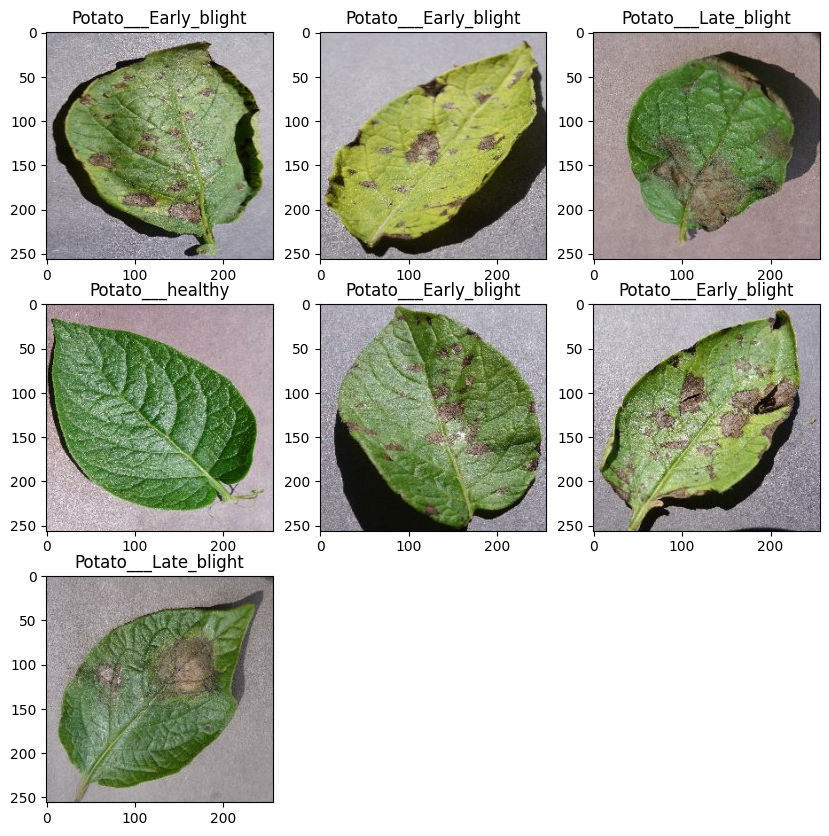

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(7):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])

In [8]:
train_length = len(dataset) * 0.8
train_size = int(train_length)

train_ds = dataset.take(train_size)
print(len(train_ds))
test_ds = dataset.skip(train_size)
print(len(test_ds))
val_length=len(dataset)*0.1
val_size=int(val_length)
val_ds=test_ds.take(val_size)
print(len(val_ds))
test_ds=test_ds.skip(val_size)
print(len(test_ds))



54
14
6
8


In [9]:
def train_test_valid_split(dataset,train_size=0.8,test_size=0.10,val_size=0.10,shuffle=True,Buffer=1000):
  if shuffle:
    dataset=dataset.shuffle(Buffer)
  train_ds=dataset.take(int(len(dataset)*train_size))
  Temp_ds=dataset.skip(int(len(dataset)*train_size))
  test_ds=Temp_ds.take(int(len(dataset)*test_size))
  val_ds=Temp_ds.skip(int(len(dataset)*test_size))
  return train_ds,test_ds,val_ds

In [10]:
train_ds,test_ds,val_ds=train_test_valid_split(dataset)
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

54
6
8


In [11]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale=tf.keras.Sequential([
    tf.keras.layers.Resizing(Image_size,Image_size),
    tf.keras.layers.Rescaling(1.0/255)
])

In [13]:
data_augmentation=tf.keras.Sequential([
   tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2)
])

In [14]:
input_shape=(Batch_size,Image_size,Image_size,channels)
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(len(class_names),activation='softmax')
])
model.build(input_shape=input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=Batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 205s 186ms/step - accuracy: 0.4926 - loss: 0.9340 - val_accuracy: 0.5742 - val_loss: 0.7908
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.6458 - loss: 0.7383 - val_accuracy: 0.7422 - val_loss: 0.7471
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.8491 - loss: 0.3856 - val_accuracy: 0.9062 - val_loss: 0.2401
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.8961 - loss: 0.2635 - val_accuracy: 0.9102 - val_loss: 0.2670
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9177 - loss: 0.1986 - val_accuracy: 0.9062 - val_loss: 0.2504
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9167 - loss: 0.1823 - val_accuracy: 0.9062 - val_loss: 0.2689
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9498 - loss: 0.1112 - val_accuracy: 0.9336 - val_loss: 0.1712
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9441 - loss: 0.1493 - val_accuracy: 0.9492 

In [18]:
scores=model.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9926 - loss: 0.0286


In [19]:
type(history)

keras.src.callbacks.history.History

In [20]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [21]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [22]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

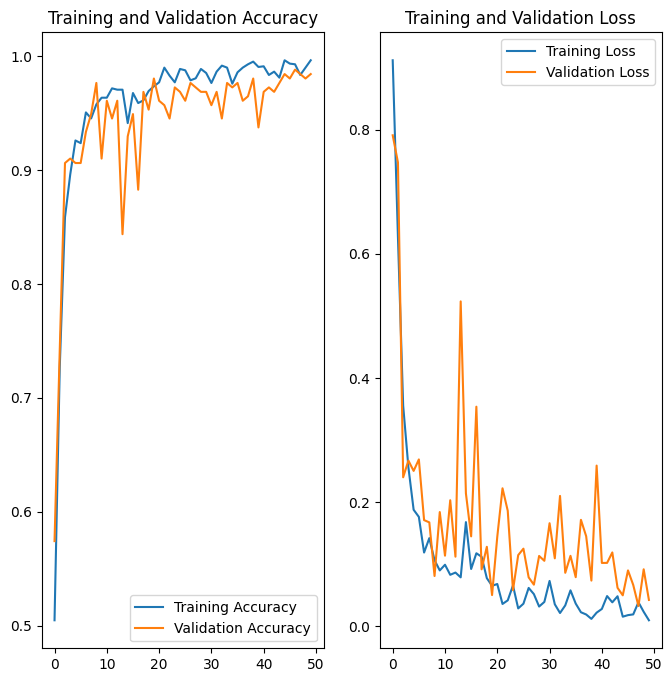

In [23]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Image to predict


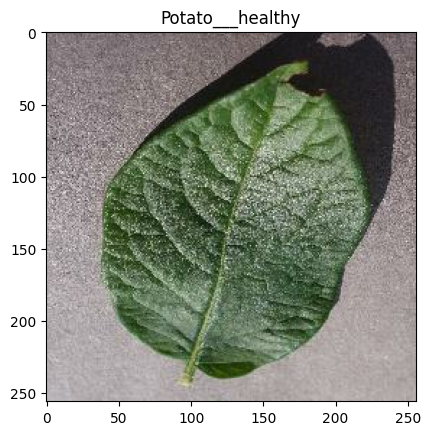

Image Label: Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Prediction : [1.2570782e-05 6.0270961e-02 9.3971646e-01]
Predicted Label: Potato___healthy


In [24]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
    print("Image to predict")
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[label_batch[0]])
    plt.show()
    print("Image Label:",class_names[label_batch[0]])
    batch_pred=model.predict(image_batch)
    print("Prediction :",batch_pred[0])
    print("Predicted Label:",class_names[np.argmax(batch_pred[0])])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


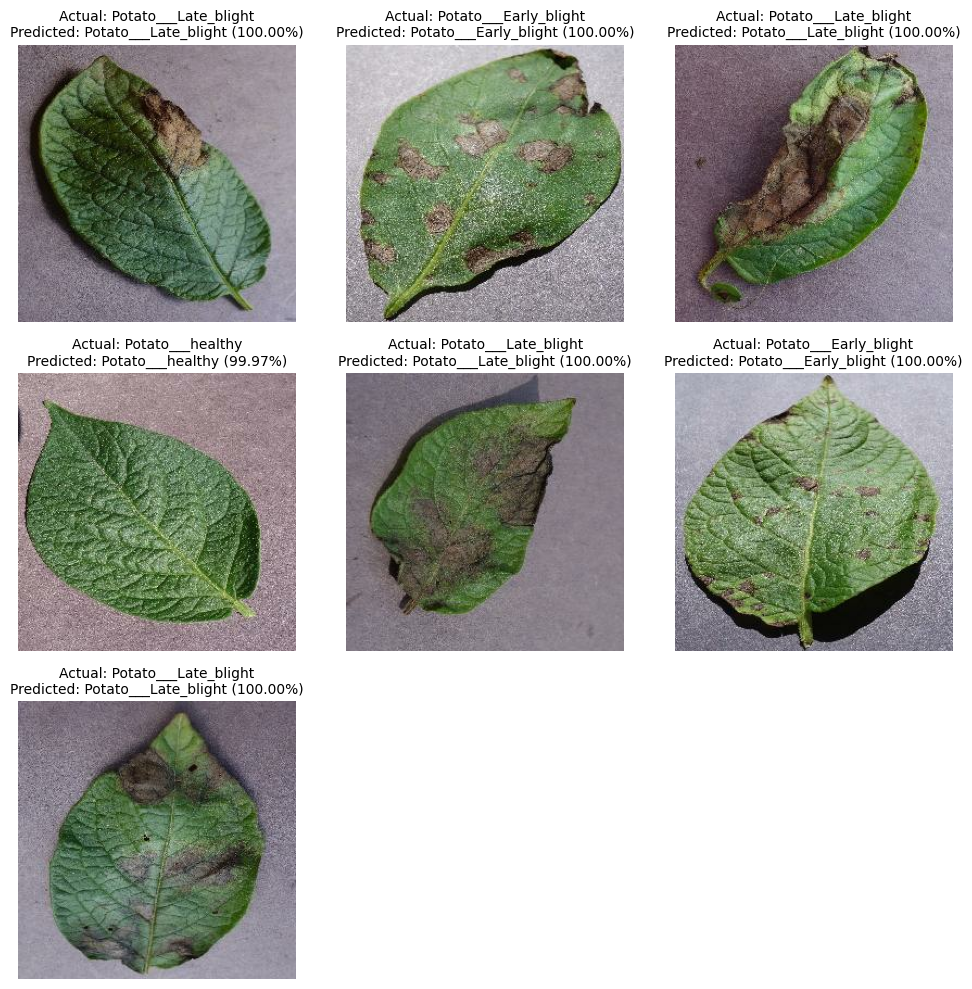

In [25]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in test_ds.take(1):
    batch_pred = model.predict(image_batch)
    for i in range(7):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')

        True_label = class_names[label_batch[i]]
        pred_idx = np.argmax(batch_pred[i])
        Predicted_label = class_names[pred_idx]
        Confidence = batch_pred[i][pred_idx]

        plt.title(
            f"Actual: {True_label}\n"
            f"Predicted: {Predicted_label} ({Confidence:.2%})",
            fontsize=10
        )
plt.tight_layout()
plt.show()


In [26]:
model.save("potato_disease_model.keras")


In [27]:
from google.colab import files
files.download("potato_disease_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>